# Goodreads Best Books

In this project, I analyzed data of a well-know social cataloging web application (Goodreads) on the best books ever according to users' votings.

## Table of Contents
1. [Import Libraries](#)
2. [Import Data](#)
3. [Data Understanding & Preparation](#)
    * [Generate New Columns](#)
    * [Overview of Missing Values](#)
    * [Remove Columns](#)
4. [Data Analysis](#)
    * [Question 1](#question-1)
    * [Question 2](#)
    * [Question 3](#) 
5. [Machine Learning (ML) Model](#)
    * [Question 4](#)
        * [Handling Missing Values & Dummy Encoding (One-Hot)](#)
        * [Decision Tree Classification](#)
6. [Evaluation](#)

## Import Libraries

In [2]:
from glob import glob
from time import time
from random import randrange
from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score

## Import Data

In [98]:
files = glob("input_data/goodreads_books_chunk_*.csv")

list_df = []

for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_df.append(df)

df = pd.concat(list_df, axis=0, ignore_index=True)

In [4]:
print('Overview of the raw imported dataset:')
df.head()

Overview of the raw imported dataset:


,id,title,link,series,cover_link,author,author_link,rating_count,review_count,average_rating,...,isbn13,asin,settings,characters,awards,amazon_redirect_link,worldcat_redirect_link,recommended_books,books_in_series,description
0,630104,Inner Circle,https://www.goodreads.com//book/show/630104.In...,(Private #5),https://i.gr-assets.com/images/S/compressed.ph...,"Kate Brian, Julian Peploe",https://www.goodreads.com/author/show/94091.Ka...,7597,196,4.03,...,9781416950417,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"726458, 726458, 1537534, 3047848, 1651302, 304...","381489, 381501, 352428, 630103, 1783281, 17832...",Reed Brennan arrived at Easton Academy expecti...
1,9487,A Time to Embrace,https://www.goodreads.com//book/show/9487.A_Ti...,(Timeless Love #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,4179,177,4.35,...,9781595542328,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"127352, 127352, 40642197, 127353, 127354, 3891...",115036,"Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,..."
2,6050894,Take Two,https://www.goodreads.com//book/show/6050894-t...,(Above the Line #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,6288,218,4.23,...,NaN,NaN,"Bloomington, Indiana(United States)",NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"706250, 706250, 666481, 11942636, 706241, 1273...","4010795, 40792877, 7306261",Filmmakers Chase Ryan and Keith Ellison have c...
3,39030,Reliquary,https://www.goodreads.com//book/show/39030.Rel...,(Pendergast #2),https://i.gr-assets.com/images/S/compressed.ph...,"Douglas Preston, Lincoln Child",https://www.goodreads.com/author/show/12577.Do...,38382,1424,4.01,...,9780765354952,NaN,"New York State(United States) New York City, N...","Aloysius X.L. Pendergast, Margo Green, William...",NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"39026, 39026, 11007668, 3986318, 51887330, 194...","67035, 39031, 39033, 136637, 136638, 30068, 39...",NaN
4,998,The Millionaire Next Door: The Surprising Secr...,https://www.goodreads.com//book/show/998.The_M...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,"Thomas J. Stanley, William D. Danko",https://www.goodreads.com/author/show/659.Thom...,72168,3217,4.04,...,9780671015206,NaN,NaN,NaN,Independent Publisher Book Award (IPPY) Nomine...,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"1052, 1052, 763362, 69571, 78427, 30186948, 10...",NaN,The incredible national bestseller that is cha...


## Data Understanding & Preparation

### Generate New Columns
1. Create new column by how many authors the book was written. To this end, comma-separated units are counted.
2. Create new column for the book's publication year.
3. Create new column if book is an award winning book (1) or not (0). By this, missing values are treated as a valuable information itself (0 = book is not award winning). Assuming the column 'awards' is reliably filled.
4. Create new column for the number of books in the series. To this end, comma-separated units are counted. Please note that the book at hand is not listed in the column 'books_in_series' (+2).
5. Improve consistent representation of missing values in 'number_of_pages' (convert 0 to NaN, because 0 pages is impossible) & 'average_rating' (convert 0 to NaN, because minimum star rating is one star) which will commonly be handled for the machine learning model later in the project.
6. Create new column for the book's main genre according to readers' votes. To this end, the numerical votes are removed (genre mix) and the first comma-separated unit is extracted (main genre). Inspection of the column 'genre_and_votes' reveals the most voted genre to be listed in the first position.

In [99]:
# 1
col = 'author'
new_col_loc = df.columns.get_loc(col) + 1
df.insert(new_col_loc, 'number_of_authors', df[col].str.count(',') + 1)

# 2
col = 'date_published'
new_col_loc = df.columns.get_loc(col) + 1
df.insert(new_col_loc, 'year_published', pd.to_numeric(df[col].str[-4:], errors='coerce'))

# 3
col = 'awards'
new_col_loc = df.columns.get_loc(col) + 1
df.insert(new_col_loc, 'is_award_winning', df[col].notna().astype(int))

# 4
col = 'books_in_series'
new_col_loc = df.columns.get_loc(col) + 1
df.insert(new_col_loc, 'number_of_books_in_series', df[col].str.count(',') + 2) 

# 5
col = ['number_of_pages','average_rating']
df[col] = df[col].replace(0, np.nan)

# 6
col = 'genre_and_votes'
new_col_loc = df.columns.get_loc(col) + 1
df.insert(new_col_loc, 'main_genre', df[col].replace(to_replace=' [0-9]+', value='', regex=True).str.split(',').str[0])
# Random sample (n=10).
random_int = randrange(start=0, stop=df.shape[0] - 10)
print(df[col][random_int:random_int + 10])

40478    Mystery 743, Mystery-Crime 293, Fiction 284, T...
40479    Autobiography-Memoir 22, Nonfiction 16, Biogra...
40480    Christian Fiction 7, Historical-Historical Fic...
40481           Science Fiction 66, Fantasy 29, Fiction 14
40482    Mystery 213, Thriller 107, Fiction 97, Suspens...
40483                                 Religion-Islam 1user
40484                                                  NaN
40485    Fiction 148, Thriller 87, War-Military Fiction...
40486    Sequential Art-Manga 517, Fantasy 50, Mystery ...
40487    Science Fiction-Alternate History 46, Science ...
Name: genre_and_votes, dtype: object


### Overview of Missing Values

In [100]:
cols_wo_missing_vals = list(df.columns[df.isnull().sum() / df.shape[0] == 0])
cols_w_missing_vals = list(df.columns[df.isnull().sum() / df.shape[0] > 0])

print('List of columns without missing values: {}'.format(cols_wo_missing_vals))

List of columns without missing values: ['id', 'title', 'link', 'author', 'number_of_authors', 'author_link', 'rating_count', 'review_count', 'five_star_ratings', 'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 'one_star_ratings', 'is_award_winning', 'amazon_redirect_link']


In [101]:
cols_missing_vals_share = df[cols_w_missing_vals].isnull().sum() / df.shape[0]
pd.options.display.min_rows = 25

print(cols_missing_vals_share.sort_values(ascending=False))

asin                         0.899692
awards                       0.796433
settings                     0.779402
characters                   0.737639
books_in_series              0.577042
number_of_books_in_series    0.577042
series                       0.553267
original_title               0.248070
isbn13                       0.243146
isbn                         0.227648
recommended_books            0.076515
worldcat_redirect_link       0.076342
publisher                    0.069657
main_genre                   0.054407
genre_and_votes              0.054407
description                  0.049330
number_of_pages              0.047836
year_published               0.016610
date_published               0.016475
cover_link                   0.011629
average_rating               0.001360
dtype: float64


### Remove Columns
ID-related, descriptive and columns with a high proportion of missing values (where missing values are meaningless) are removed.

*Meaningful missing values: e.g. number_of_books_in_series - missing value means 0, book is not part of series. Meaningless missing values: e.g. settings - missing value can neither be interpreted nor replaced in a reasonable way.*

In [93]:
remove_cols_list = ['id', 'title', 'original_title', 'link', 'author_link', 'amazon_redirect_link', 'asin',
                    'books_in_series', 'series', 'isbn', 'isbn13', 'worldcat_redirect_link', 'recommended_books',
                    'cover_link', 'description', 'characters', 'genre_and_votes', 'author', 'publisher',
                    'date_published', 'awards', 'settings']
df.drop(remove_cols_list, inplace=True, axis=1)

## Data Analysis

#### Filter by year 1800-2020: Focus on the last 220 years.

In [94]:
df_1800_2020 = df[(df['year_published'] > 1800) & (df['year_published'] < 2020)]

print('The preprocessed and filtered dataset (df_1800_2020) contains {} rows and {} columns.'.format(
    df_1800_2020.shape[0],
    df_1800_2020.shape[1]))

The preprocessed and filtered dataset (df_1800_2020) contains 50619 rows and 14 columns.


In [74]:
print('Overview of all numerical columns in the dataset (df_1800_2020)):')

df_1800_2020.describe()

Overview of all numerical columns in the dataset (df_1800_2020)):


,number_of_authors,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages,year_published,is_award_winning,number_of_books_in_series
count,50619.000000,5.061900e+04,50619.000000,50559.000000,5.061900e+04,5.061900e+04,50619.000000,50619.000000,50619.000000,48832.000000,50619.000000,50619.000000,21740.000000
mean,1.336850,1.909965e+04,1033.043778,4.023377,7.937755e+03,6.328967e+03,3477.757818,938.524507,416.647188,329.301483,1996.909421,0.208795,6.086155
std,1.409129,1.172637e+05,4109.211193,0.331643,5.949149e+04,3.495888e+04,18128.333635,5844.640715,3870.709727,247.741340,27.895105,0.406452,3.339628
min,1.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1801.000000,0.000000,2.000000
25%,1.000000,3.690000e+02,34.000000,3.820000,1.270000e+02,1.190000e+02,69.000000,17.000000,6.000000,214.000000,1994.000000,0.000000,3.000000
50%,1.000000,2.389000e+03,170.000000,4.030000,8.390000e+02,7.990000e+02,471.000000,111.000000,38.000000,304.000000,2007.000000,0.000000,5.000000
75%,1.000000,9.506500e+03,640.000000,4.220000,3.454000e+03,3.265500e+03,1902.500000,458.000000,154.000000,392.000000,2012.000000,0.000000,10.000000
max,52.000000,6.801077e+06,169511.000000,5.000000,4.414877e+06,1.868421e+06,980183.000000,529060.000000,537793.000000,14777.000000,2019.000000,1.000000,11.000000


#### Popularity Measures Plot Preparation | Function
The function **popularity_measures_plot_prep** is defined in order to provide standardized data aggregation using the *.groupby* method for plot preparation in the following visualizations. An input dataframe of choice will be grouped by a desired set of dimensions on an average rating measure and an award winning related measure. Based on these measures, a fixed set of popularity measures is calculated: book count, average rating grand mean, average rating standard deviation, award winning count, award winning share.

In [75]:
def popularity_measures_plot_prep(df_input, group_by_cols, avg_rating_col=['average_rating'],
                                  award_col=['is_award_winning']):
    '''
    INPUT:
    df_input - a dataframe holding all the variables of interest
    group_by_cols - a list of strings holding the name of the column(s) the data should be grouped by
    avg_rating_col - a list holding the column with average readers' rating
    award_col - a list holding the column informing if book is an award winning book (1) or not (0)

    OUTPUT:
    df_grouped - a dataframe holding grouped popularity measures by group_by_cols (indices are group_by_cols)

    THE FUNCTION calculates the following popularity measures by group_by_cols:
    1. book_count
    2. avg_rating_mean (grand mean)
    3. avg_rating_std (standard deviation)
    4. award_winning_count
    5. award_winning_share (proportion)
    '''
    df_computing_avg_rating = group_by_cols + avg_rating_col
    df_computing_award = group_by_cols + award_col

    df_book_count = df_input[df_computing_avg_rating].groupby(group_by_cols).count().rename(
        columns={str(avg_rating_col[0]): 'book_count'})
    df_avg_rating_mean = df_input[df_computing_avg_rating].groupby(group_by_cols).mean().rename(
        columns={str(avg_rating_col[0]): 'avg_rating_mean'})
    df_avg_rating_std = df_input[df_computing_avg_rating].groupby(group_by_cols).std().rename(
        columns={str(avg_rating_col[0]): 'avg_rating_std'})
    df_award_count = df_input[df_computing_award].groupby(group_by_cols).sum().rename(
        columns={str(award_col[0]): 'award_winning_count'})

    df_singles = [df_book_count, df_avg_rating_mean, df_avg_rating_std, df_award_count]
    df_grouped = reduce(lambda left, right: pd.merge(left, right, on=group_by_cols), df_singles)
    df_grouped['award_winning_share'] = df_grouped['award_winning_count'] / df_grouped['book_count']

    return df_grouped

### Question 1: Is there a shift in popularity measures over time? Are books from certain time periods generally more popular? <a id="question-1"></a>

#### Popularity Measures Over Time | Visualization
Using df_1800_2020 (filtered by year)

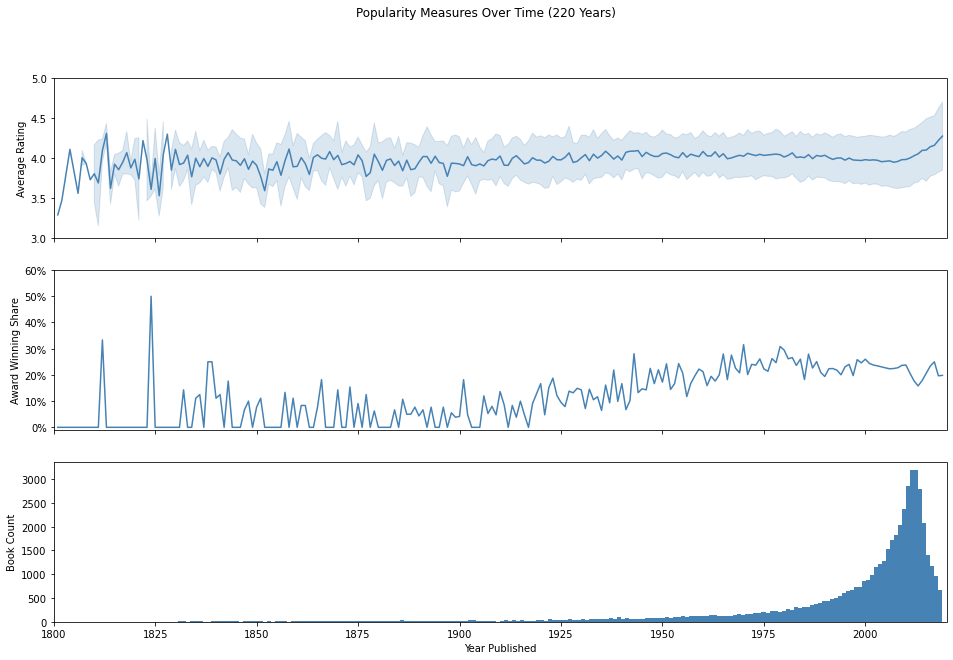

In [76]:
df_grouped = popularity_measures_plot_prep(df_1800_2020, group_by_cols=['year_published'])

fig, ax = plt.subplots(3, figsize=(16, 10), sharex=True)
fig.suptitle('Popularity Measures Over Time (220 Years)')

df_grouped.plot(ax=ax[0], y='avg_rating_mean', kind='line', color='steelblue', legend=False)
ax[0].fill_between(df_grouped.index, df_grouped['avg_rating_mean'] - df_grouped['avg_rating_std'],
                   df_grouped['avg_rating_mean'] + df_grouped['avg_rating_std'],
                   alpha=0.2, color='steelblue')
ax[0].set_ylabel('Average Rating')
ax[0].set_ylim(3, 5)

df_grouped.plot(ax=ax[1], y='award_winning_share', kind='line', color='steelblue', legend=False)
ax[1].set_ylabel('Award Winning Share')
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(['{:,.0%}'.format(y) for y in yticks])
ax[1].set_ylim(-0.01, 0.6)

ax[2].hist(df_1800_2020['year_published'], bins=220, color='steelblue')
ax[2].set_ylabel('Book Count')
ax[2].set_xlabel(df_grouped.index.name.replace('_', ' ').title())
ax[2].set_xlim(1800, 2020)

plt.show()

In [77]:
df_grouped.sort_values('book_count', ascending = False)

,book_count,avg_rating_mean,avg_rating_std,award_winning_count,award_winning_share
year_published,,,,,
2012.0,3198,4.029737,0.342422,567,0.177298
2013.0,3196,4.053676,0.353427,505,0.158010
2011.0,2845,4.002032,0.356834,587,0.206327
2014.0,2794,4.097215,0.348067,499,0.178597
2010.0,2366,3.982921,0.344579,562,0.237532
2015.0,2064,4.101153,0.389981,426,0.206395
2009.0,2039,3.981050,0.352236,482,0.236390
2008.0,1835,3.958725,0.336985,417,0.227248
2007.0,1720,3.948703,0.322430,386,0.224419


**Interpretation:**

The **average readers' ratings** seem to settle around a grand mean of about 4 with a quite constant standard deviation of ratings (first subplot). In the recent years (since around 2010), a slight increase to a grand mean of about 4.25 is visible. This could point to a recency effect on the average rating of books resulting in more positive ratings of recently published (and thus, recently read) books.

The **award winning share** increases since 1900 from 0-10% to around 20-25% (second subplot). Either recently published books are more likely to win awards because they are of higher literary value, or (as a probably more likely explanation) more and different awards were popping up by different organizations in the recent years. This could generally increase the chance of books winning at least one award.

The **histogram on the books' publication year** clearly shows the majority of books being published in the 2000s with a peak around 2012/2013 (third subplot). Especially in earlier years (1800 - 1900), higher variation of the average readers' ratings grand mean as well as of the award winning share can be observed due to the very small sample size of published books during that time in this dataset making this time period harder to reliably analyze and interpret.

### Question 2: What genres are most popular and how did genre popularity develop over time?

#### Filter and group by top genres: Focus on the top genres by book count >= 1000.

In [78]:
df_top_genres = df_1800_2020.groupby('main_genre').filter(lambda x: len(x) >= 1000)

#### Genre Popularity | Visualization
Using df_top_genres (filtered by top genres)

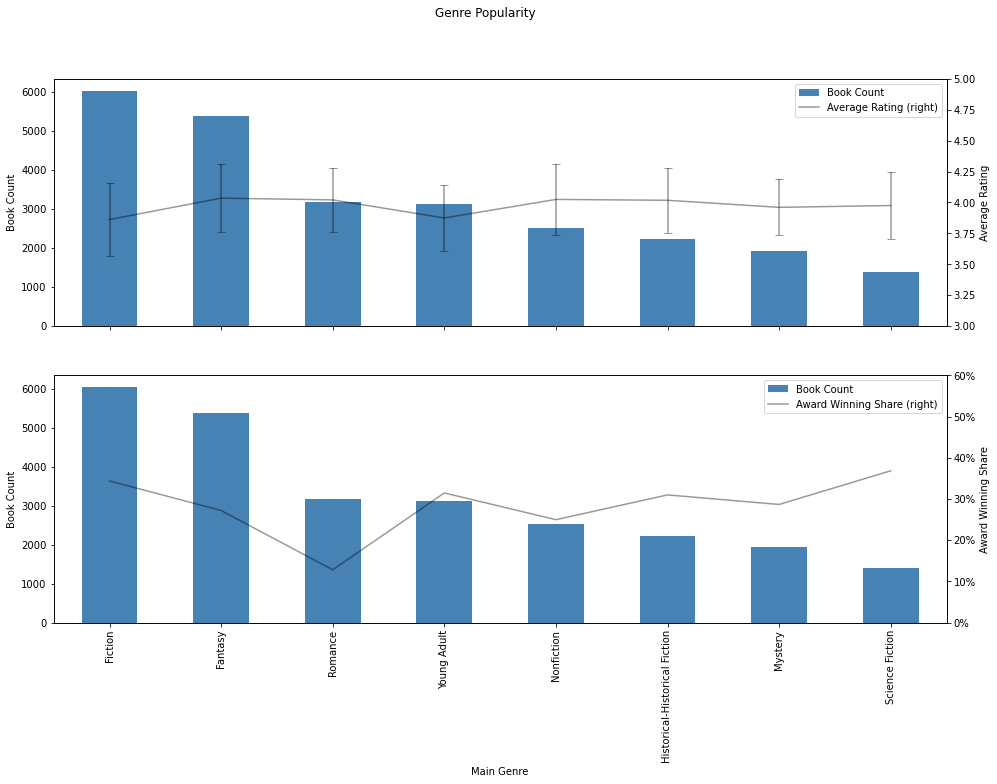

In [79]:
df_grouped = popularity_measures_plot_prep(df_top_genres, group_by_cols=['main_genre'])
df_grouped = df_grouped.sort_values('book_count', ascending=False)

fig, ax = plt.subplots(2, figsize=(16, 10), sharex=True)
fig.suptitle('Genre Popularity')

df_grouped.plot(ax=ax[0], y='book_count', kind='bar', color='steelblue', label='Book Count')
df_grouped.plot(ax=ax[0], y='avg_rating_mean', secondary_y=True, yerr='avg_rating_std', color='black', alpha=0.4,
                capsize=4, label='Average Rating')
ax[0].set_ylabel('Book Count')
ax[0].right_ax.set_ylabel('Average Rating')
ax[0].right_ax.set_ylim(3, 5)

df_grouped.plot(ax=ax[1], y='book_count', kind='bar', color='steelblue', label='Book Count')
df_grouped.plot(ax=ax[1], y='award_winning_share', secondary_y=True, color='black', alpha=0.4,
                label='Award Winning Share')
ax[1].right_ax.set_ylim(0, 0.6)
ax[1].set_ylabel('Book Count')
ax[1].right_ax.set_ylabel('Award Winning Share')
ax[1].set_xlabel(df_grouped.index.name.replace('_', ' ').title())
yticks = ax[1].right_ax.get_yticks()
ax[1].right_ax.set_yticks(yticks)
ax[1].right_ax.set_yticklabels(['{:,.0%}'.format(y) for y in yticks])
ax[1].tick_params(axis='x', labelrotation=90)

plt.show()

In [80]:
df_grouped.sort_values('book_count', ascending = False)

,book_count,avg_rating_mean,avg_rating_std,award_winning_count,award_winning_share
main_genre,,,,,
Fiction,6035,3.862209,0.292462,2075,0.343828
Fantasy,5384,4.035314,0.278026,1465,0.272103
Romance,3169,4.021117,0.260267,406,0.128116
Young Adult,3130,3.874617,0.269998,985,0.314696
Nonfiction,2526,4.024893,0.286858,631,0.249802
Historical-Historical Fiction,2223,4.017827,0.263666,689,0.309942
Mystery,1925,3.960706,0.226878,552,0.286753
Science Fiction,1395,3.975470,0.269251,514,0.368459


**Interpretation:**

The top 3 genres according to book count are Fiction, Fantasy and Romance (although closely followed by Young Adult). While the **average readers' ratings** grand mean is quite consistenty located around 3.8-4.0 over the top genres (first subplot), the **award winning share** is lowest for genre Romance with 13% (third subplot). Science Fiction (37%) and Fiction (34%) are the genres with the highest award winning share.

#### Genre Popularity Over Time | Visualization
Using df_top_genres (filtered by top genres)

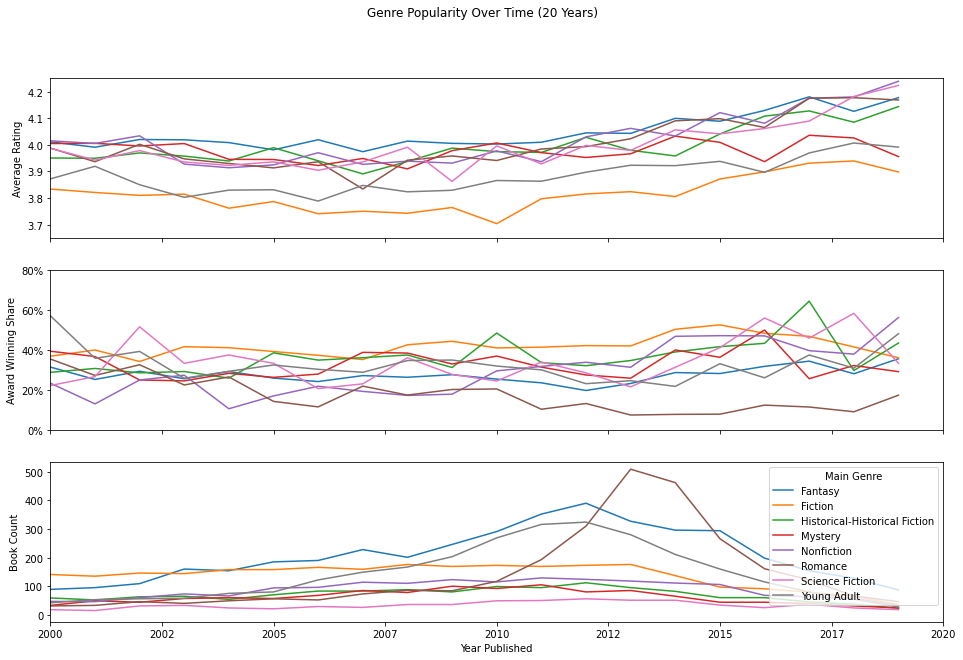

In [81]:
df_grouped = popularity_measures_plot_prep(df_top_genres, group_by_cols=['year_published', 'main_genre'])

fig, ax = plt.subplots(3, figsize=(16, 10), sharex=True)
fig.suptitle('Genre Popularity Over Time (20 Years)')

df_grouped['avg_rating_mean'].unstack().plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Average Rating')
ax[0].set_ylim(3.65, 4.25)
ax[0].set_xlim(2000, 2020)
xticks = ax[0].get_xticks()
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([int(x) for x in xticks])

df_grouped['award_winning_share'].unstack().plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Award Winning Share')
ax[1].set_ylim(0, 0.8)
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(['{:,.0%}'.format(y) for y in yticks])
xticks = ax[1].get_xticks()
ax[1].set_xticks(xticks)
ax[1].set_xticklabels([int(x) for x in xticks])

df_grouped['book_count'].unstack().plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Book Count')
ax[2].set_xlabel(df_grouped.index.names[0].replace('_', ' ').title())
xticks = ax[2].get_xticks()
ax[2].set_xticks(xticks)
ax[2].set_xticklabels([int(x) for x in xticks])

plt.legend(title='Main Genre', loc='upper right')

plt.show()

**Interpretation:**

For this timeline analysis, the focus is on the past 20 years since the **histogram on the books' publication year** in the visualization above clearly shows the majority of books being published in the 2000s.

Over time, **average readers' ratings** do not show genre-specific development (first subplot). Instead, the grand mean shows a slight increase for all genres during the recent years (since around 2010) as was also shown in the first visualization for [Question 1](#question-1).

For **award winning share**, a slight diverging trend between the genre Romance (below 20%) and all other genres (above 20%) can be observed starting after 2010 (second subplot).

In contrast, especially the genre Romance as well as Fantasy and Young Adult are contributing to the high **book count in publication years** after 2010 (third subplot).

### Question 3: Are readers' ratings on books reflected in winning an award granted by a committee?

#### Reader's Rating & Awards | Visualization
Using df_1800_2020 (filtered by year)

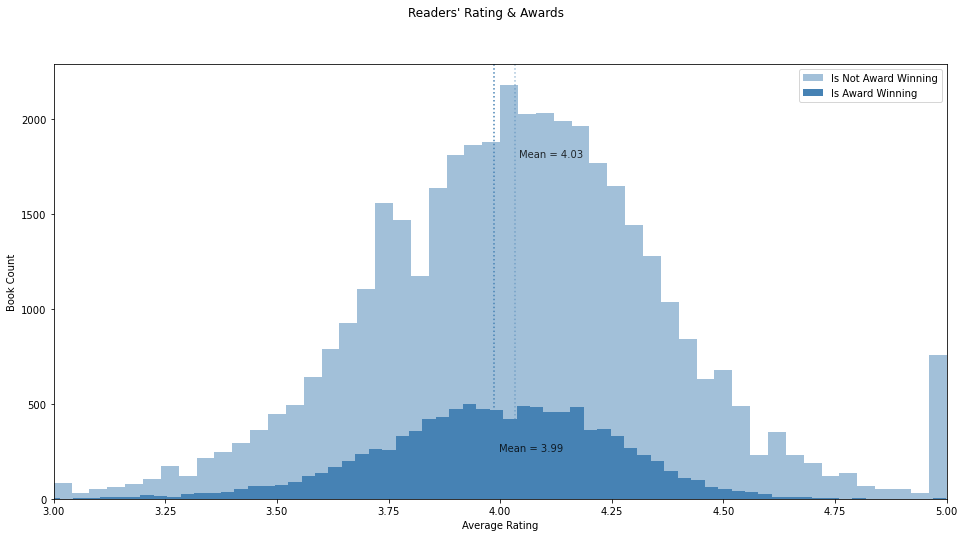

In [82]:
df_no_award = df_1800_2020['average_rating'][df_1800_2020.is_award_winning == 0] # filter on no award winning books
df_award = df_1800_2020['average_rating'][df_1800_2020.is_award_winning == 1] # filter on award winning books

mean_no_award =df_no_award.mean()
mean_award = df_award.mean()

fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle("Readers' Rating & Awards")

ax.hist(df_no_award, bins=100, color='steelblue', alpha=0.5, label='Is Not Award Winning')
ax.axvline(mean_no_award, linestyle = ":", color='steelblue', alpha=0.5)
ax.text(mean_no_award + .01, 1800, 'Mean = ' + str(round(mean_no_award,2)), size = 10, alpha = 0.8)
ax.hist(df_award, bins=100, color='steelblue', alpha=1, label='Is Award Winning')
ax.axvline(mean_award, linestyle = ":", color='steelblue', alpha=1)
ax.text(mean_award + .01, 250, 'Mean = ' + str(round(mean_award,2)), size = 10, alpha = 0.8)
ax.set_ylabel('Book Count')
ax.set_xlabel('Average Rating')
ax.set_xlim([3, 5])

ax.legend(loc='upper right')

plt.show()

**Interpretation:**

The overlapping distributions of **award winning books and no-award winning books on average readers' ratings** appear very similiar - with similar peaks and spreads. It can be concluded, that award winning books do not receive higher ratings by readers than no-award winning books. Whether a book is award winning or not does not seem to have an influence on average readers' ratings.

## Machine Learning (ML) Model
Using df (no additional filter after preprocessing).

### Question 4: How well can we predict whether a book will be award winning or not by publicly available data from a social cataloging web application?

#### Relationships of Numerical Variables | Visualization
Using df_1800_2020 (filtered by year)

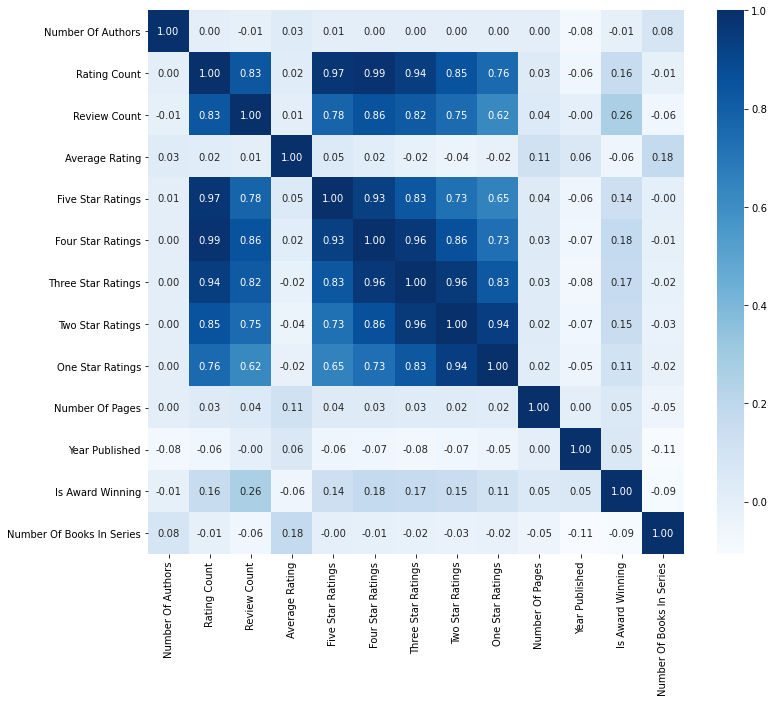

In [83]:
num_df = df_1800_2020.select_dtypes(include=['number']) # select all numeric variables
num_cols_lst = num_df.columns

fig, ax = plt.subplots(figsize=(12, 10))

sn.heatmap(df_1800_2020.corr(), annot=True, fmt='.2f', cmap='Blues', # correlation matrix uses default method='pearson'
           xticklabels=[x.replace('_', ' ').title() for x in num_cols_lst],
           yticklabels=[y.replace('_', ' ').title() for y in num_cols_lst])

plt.show()

**Interpretation:**

Evidently, the highest positive correlations are found between the number of **One to Five Star Ratings due to Rating Count**. The more ratings are available for a book, the more ratings are consequently available on each level (One Star to Five Stars). Furthermore, Review Count is also positively correlated with Rating Count (r = 0.83) which indicates frequently star-rated books to receive more written reviews.

When looking at **Is Award Winning**, Review Count is weakly positively correlated (r = 0.26) which could hint to more written reviews on award winning books than on no-award winning books. The relationship to Rating Count is weaker (r = 0.16).

Furthermore, **Average Rating** is weakly positively correlated to Number of Books in Series (r = 0.18) and to Number of Pages (r = 0.11). With more books belonging to a series and more pages average readers' ratings seem to increase.

Of course, these correlations are of descriptive nature for now and could be spurious findings. In order to check for significance of these observations, statistical tests would have to be conducted.

### Handling Missing Values & Dummy Encoding (One-Hot)

#### Numerical Variables
For different use cases, different handling of missing values is applied.

- Replace nan by 0. - If nan itself can be interpreted as a meaningful zero.
- Replace nan by mode. - If mode is a better representation of central tendency than mean.
- Replace nan by mean. - If mean is a better representation of central tendency than mode.

Please compare code documentation for handling of missing values on specific columns.

In [97]:
num_df = df.select_dtypes(include=['number']) # select all numeric variables
num_cols_lst = num_df.columns

method_0 = 'number_of_books_in_series' # nan interpreted as book is not part of a series, thus 0
method_mode = 'year_published' # mode to represent central tendency better than mean (reduce impact of outlier years)

for col in num_cols_lst:
    print('Column ' + str(col) + ' had a missing value share of ' + str(df[col].isnull().mean())) 
    if col == method_0:
        # columns for which fillna uses 0
        df[col].fillna(0, inplace=True)
    elif col == method_mode:
        # columns for which fillna uses mode
        df[col].fillna((df[col].mode()[0]), inplace=True)
    else:
        # all other columns for which fillna uses mean as a default (here, it applies to 'number_of_pages' only)
        df[col].fillna((df[col].mean()), inplace=True)

Column number_of_authors had a mssing value share of 0.0
Column rating_count had a mssing value share of 0.0
Column review_count had a mssing value share of 0.0
Column average_rating had a mssing value share of 0.0
Column five_star_ratings had a mssing value share of 0.0
Column four_star_ratings had a mssing value share of 0.0
Column three_star_ratings had a mssing value share of 0.0
Column two_star_ratings had a mssing value share of 0.0
Column one_star_ratings had a mssing value share of 0.0
Column number_of_pages had a mssing value share of 0.0
Column year_published had a mssing value share of 0.0
Column is_award_winning had a mssing value share of 0.0
Column number_of_books_in_series had a mssing value share of 0.0


#### Categorical Variables

Use one-hot encoding instead of LabelEncoder or OrdinalEncoder from scikit.preprocessing, because the relevant categorical input is on a nominal scale.

In [85]:
cat_df = df.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

for col in cat_cols_lst:
    try:
        # For each categorical variable add dummy variable, drop original column.
        print("Processing column " + col)
        df = pd.concat(
            [df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)],
            axis=1)
        print("Done")
    except:
        continue

Processing column main_genre
Done


### Decision Tree Classification

In [86]:
# Split dataframe into labels (y) and features (X)
label_col = 'is_award_winning'
X = df.drop(label_col, axis=1)
y = df[label_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=31)

#### Optimal Accuracy | Function
The function **optimal_dt_accuracy** is defined in order to enable flexible investigation of a decision tree's train & test accuracy on different expressions of the *max_depth* hyperparameter. A decision tree model is fitted on train and test features as well as separate train and test labels for each maximum depth value. The resulting train and test accuracy values are plotted.

In [87]:
def optimal_dt_accuracy(X_train, y_train, X_test, y_test, max_depth_list):
    '''
    INPUT:
    X_train - training dataframe holding all features (after dummy encoding)
    y_train - training series holding the labels
    X_test - test dataframe holding all features (after dummy encoding)
    y_test - test series holding the labels
    max_depth_list - a list holding all max_depth values the decision tree should be optimized on

    OUTPUT:
    Plot of train and test accuracy for all max_depth values.

    THE FUNCTION plots train and test accuracy in order to find the optimal max_depth value.
    '''
    train_accuracy = []
    test_accuracy = []

    for x in max_depth_list:
        clf = tree.DecisionTreeClassifier(max_depth=x)
        clf.fit(X_train, y_train)

        pred_y_train = clf.predict(X_train)
        pred_y_test = clf.predict(X_test)

        train_accuracy.append(accuracy_score(y_train, pred_y_train))
        test_accuracy.append(accuracy_score(y_test, pred_y_test))
        print('Accuracy with maximum depth = {} computed.'.format(str(x)))

    x = np.arange(len(max_depth_list)) + 1

    fig, ax = plt.subplots(figsize=(16, 8))
    plt.plot(x, train_accuracy, color='indianred', label='Train Accuracy')
    plt.plot(x, test_accuracy, color='steelblue', label='Test Accuracy')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, 5.5, 1))
    yticks = ax.get_yticks()
    ax.set_yticks(yticks)
    ax.set_yticklabels(['{:,.1%}'.format(y) for y in yticks])
    plt.legend(loc='upper right')
    plt.show()

#### Optimal Accuracy | Visualization

Accuracy with maximum depth = 1 computed.
Accuracy with maximum depth = 2 computed.
Accuracy with maximum depth = 3 computed.
Accuracy with maximum depth = 4 computed.
Accuracy with maximum depth = 5 computed.


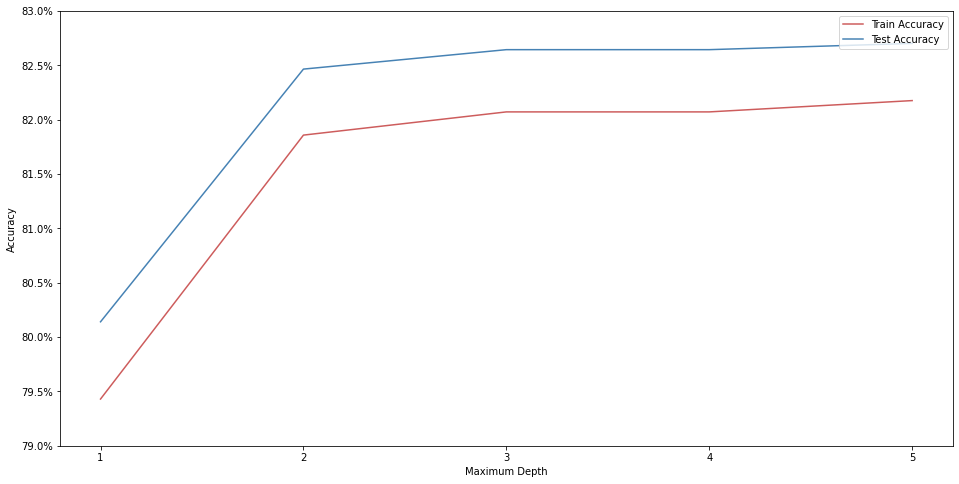

In [88]:
optimal_dt_accuracy(X_train, y_train, X_test, y_test, max_depth_list=[1, 2, 3, 4, 5])

**Interpretation:**

Along all inspected values of the hyperparameter max_depth, the test accuracy turns out to be ~0.5 percentage points higher than the train accuracy, which does not point towards an overfitted model. The model generally rather appears to be underfitting (as discussed in the section below) considering the highest test accuracy scores around 82.6% (starting with a maximum depth = 3). For this reason, max_depth = 3 is chosen for the final decision tree model below.

#### Decision Tree | Training & Accuracy
A max_depth = 3 is chosen based on the previous inspection of optimal train & test accuracy.

In [89]:
# Classifier initialization
clf3 = tree.DecisionTreeClassifier(max_depth=3)

# Classifier fit
t0 = time()
clf3 = clf3.fit(X_train, y_train)
print("Training time:", round(time() - t0, 3), "s")

# Prediction
t0 = time()
pred_y_test = clf3.predict(X_test)
print("Prediction time:", round(time() - t0, 3), "s")

pred_y_train = clf3.predict(X_train)

# Accuracy
print("Test accuracy:", accuracy_score(y_test, pred_y_test))
print("Train accuracy:", accuracy_score(y_train, pred_y_train))

Training time: 1.441 s
Prediction time: 0.277 s
Test accuracy: 0.8264367816091954
Train accuracy: 0.8207121158214511


**Interpretation:**

A test accuracy of 82,64% is not satisfying. Especially, in the context of an overall no-award winning share of 79,12%, this decision tree model improves classification by only a few percentage points (in comparison to simply labeling "not award winning" for all books). Most data columns available in this dataset contain objective information on the books (such as 'date_published' (used as 'year_published'), 'books_in_series' (used as 'number_of_books_in_series'), 'authors' (used as 'number_of_authors'), 'number_of_pages'). Presumably, more content and topic related features as well as specifics on award types and the award granting committee could improve the classification.

#### Decision Tree | Visualization

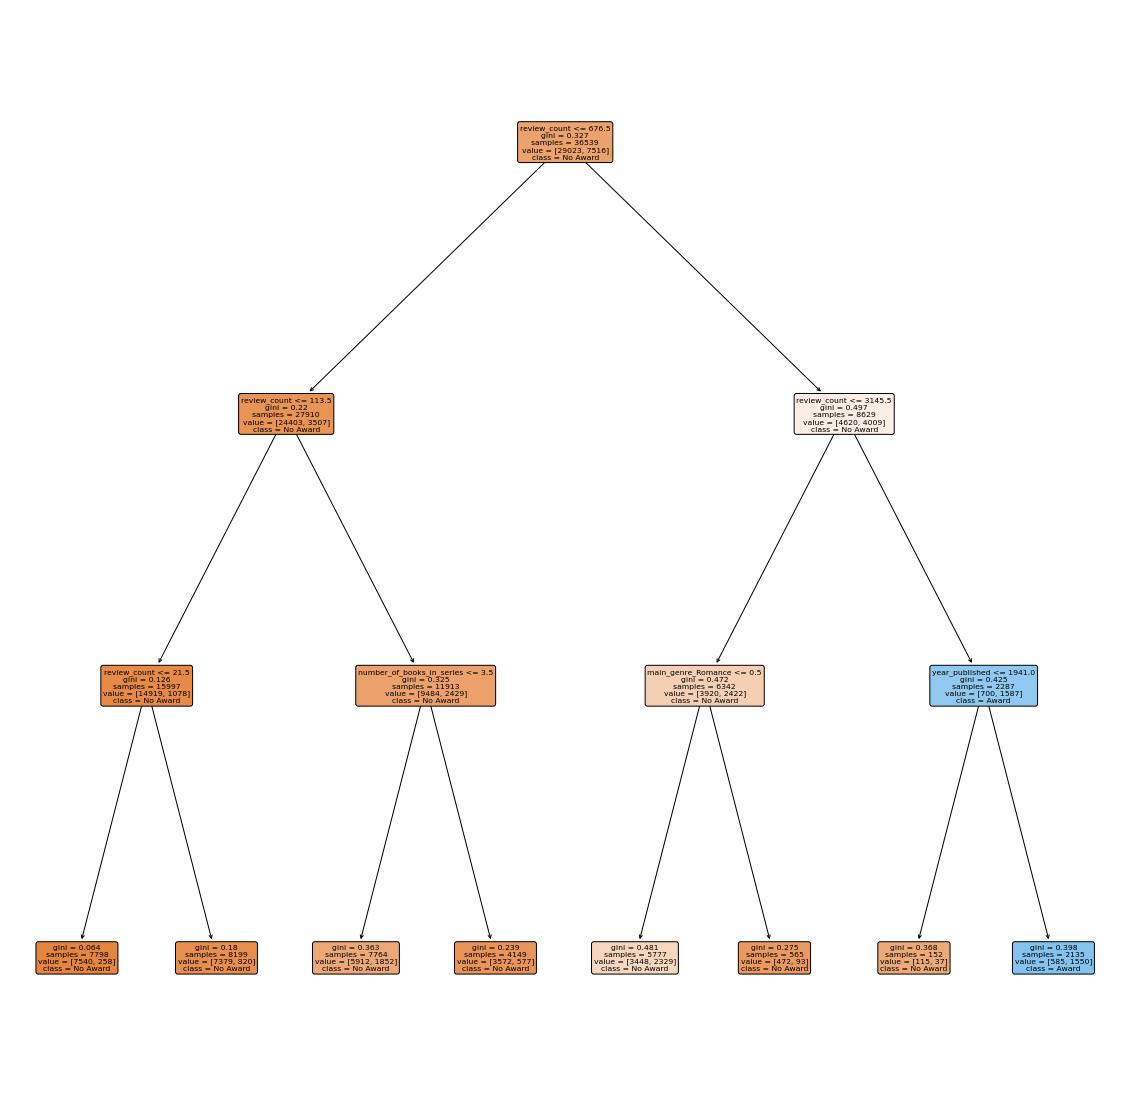

In [90]:
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(clf3, feature_names=X.columns, class_names=['No Award', 'Award'], filled=True, label='all', rounded=True)

plt.show()

**Interpretation:**

## Evaluation